In [16]:
using FFTW, Plots, LinearAlgebra, LaTeXStrings, SparseArrays, Printf
include("./amath586.jl")
using .amath586
import Base: diff, *

# Exponential integration using the FFT ( $O(m \log m)$ complexity )

We will work on the periodic interval $[-L,L)$ with a uniform mgrid.

In [2]:
L = 11
m = 20
X = -L .+ 2*L*(0:m-1)/m

-11.0:1.1:9.9

Given a function $f: [-L, L) \to \mathbb C$ the FFT allows us to find sum of complex exponentials that interpolate it at the chosen mgrid points.  The following is a handy way to see what `fft` is doing.

In [3]:
rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
mifft = x -> mfftshift(ifft(mfftshift(x),1))
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n

#11 (generic function with 1 method)

In [4]:
N₋ = m -> convert(Int64,floor(m/2))
N₊ = m -> convert(Int64,floor((m-1)/2))

#15 (generic function with 1 method)

In [5]:
f = x -> exp.(4im*pi*x/L)
hcat( mfft(f(mgrid(m,L))) |> rnd, -N₋(m):N₊(m))

20×2 Matrix{ComplexF64}:
  0.0-0.0im  -10.0+0.0im
  0.0+0.0im   -9.0+0.0im
 -0.0-0.0im   -8.0+0.0im
 -0.0-0.0im   -7.0+0.0im
  0.0+0.0im   -6.0+0.0im
  0.0-0.0im   -5.0+0.0im
  0.0+0.0im   -4.0+0.0im
  0.0-0.0im   -3.0+0.0im
 -0.0+0.0im   -2.0+0.0im
 -0.0-0.0im   -1.0+0.0im
 -0.0+0.0im    0.0+0.0im
  0.0-0.0im    1.0+0.0im
 -0.0-0.0im    2.0+0.0im
  0.0+0.0im    3.0+0.0im
 20.0+0.0im    4.0+0.0im
 -0.0+0.0im    5.0+0.0im
  0.0-0.0im    6.0+0.0im
 -0.0-0.0im    7.0+0.0im
 -0.0+0.0im    8.0+0.0im
  0.0-0.0im    9.0+0.0im

In [6]:
u = 1.0:10 |> Array
u |> display
u - mifft(mfft(u)) |> rnd

10-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

10-element Vector{ComplexF64}:
  0.0 - 0.0im
 -0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im
  0.0 - 0.0im

The behavior here is a bit different depending on whether $m$ is even or odd.  For $m \geq 1$, Define $m_+ = \lfloor (m-1)/2 \rfloor$, $m_- = \lfloor m/2 \rfloor$.  These values are set so that $m_+ + m_- + 1 = m$.  Then if $m$ is even `c = fftshift(fft(fftshift(f(X))))` returns coefficients $c_1 = \mathrm{\tt c[1]},\ldots,c_m = \mathrm{\tt c[m]}$ such that

\begin{align*}
f(x) \approx I_mf(x) := \frac{1}{m} \sum_{\omega = - m_-}^{m_+} c_{\omega + m_- + 1} e^{\pi i \omega x/L},
\end{align*}

in the sense that $I_mf(\mathrm{\tt X}) = f(\mathrm{\tt X})$, i.e., $I_mf$ interpolates $f$ at the values `X`.  More is true.  One can define a norm by

\begin{align*}
\|f\|_{H^s}^2 := \sum_{\omega=-\infty}^{\infty} (1 + |\omega|)^{2s} |\hat f_\omega|^2, \quad \hat f_\omega = \frac{1}{2L} \int_{-L}^L e^{-\pi i \omega x/L} f(x) dx.
\end{align*}

A theorem of Kress and Sloan (1993) states that

\begin{align*}
\|f - I_mf\|_{H^s} \leq C_{L,t,s} m^{s-t} \|f\|_{H^t}, \quad s > 1/2.
\end{align*}

So, if $f$ is infinitely differentiable and periodic then $t$ can be as large as one likes, giving

\begin{align*}
f - I_mf = O(m^{-\sigma}), \quad \text{ for any } \sigma > 0.
\end{align*}

This is often termed "spectral convergence" --- at a rate faster than any polynomial rate. 

If $m$ is odd, the coefficients aren't quite the same.

In [7]:
m = 6
L = 10
f = x -> exp.(1*1im*pi*x/L)
out = mfft(f(mgrid(m,L))) |> rnd

6-element Vector{ComplexF64}:
  0.0 + 0.0im
 -0.0 + 0.0im
  0.0 + 0.0im
  0.0 + 0.0im
  6.0 + 0.0im
 -0.0 + 0.0im

In [8]:
m = 5
L = 10
f = x -> exp.(1*1im*pi*x/L)
out = mfft(f(mgrid(m,L))) |> rnd

5-element Vector{ComplexF64}:
    -0.0 - 0.0im
     0.0 + 0.0im
     0.0 - 0.0im
 4.04508 + 2.93893im
     0.0 - 0.0im

In [22]:
struct trig_interp
    L::Float64
    c::Vector{Complex{Float64}}
end

function (tr::trig_interp)(x) # just sums the Fourier series!
    m = length(tr.c)
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*x/tr.L + mm*σ)
    ex1 = exp.(1im*pi*x/tr.L-σ)
    sum = tr.c[1]*ex
    for i = 2:length(tr.c)
        ex  =  ex.*ex1
        sum += tr.c[i]*ex
    end
    return sum/m
end

function *(tr1::trig_interp,tr2::trig_interp)
    trig_interp(tr1.L,mfft(mifft(tr1.c).*mifft(tr2.c)))
end

function *(a::Number,tr2::trig_interp)
    trig_interp(tr2.L,a*tr2.c)
end

* (generic function with 423 methods)

In [10]:
L = 10.
n = 51
X = mgrid(n,L)
f = x -> exp.(-cos.(pi*x/L))
fm = trig_interp(L,mfft(f(X)));

In [20]:
(fm*fm)(.3)

0.13654187577016433 - 2.9685166705552896e-17im

In [24]:
(5*fm)(.3)

1.847578657122368 + 3.7844188833797257e-16im

In [25]:
5*f(.3)

1.847578657122366

In [52]:
fm(.3)

0.3695157314244734 + 6.012959203665578e-17im

In [53]:
f(.1) - fm(.1)

-1.6653345369377348e-16 - 1.38591858689855e-16im

In [55]:
L = 10
f = x -> exp.(-cos.(10*pi*x/L))

data = []
ms = []
for m = 11:5:350
    X = mgrid(m,L)
    fn = trig_interp(L,mfft(f(X)))
    append!(data,abs(fn(.1)-f(.1)))
    append!(ms,m)
end

A concave graph indicates spectral convergence of $I_nf(0.1)$ to $f(0.1)$.

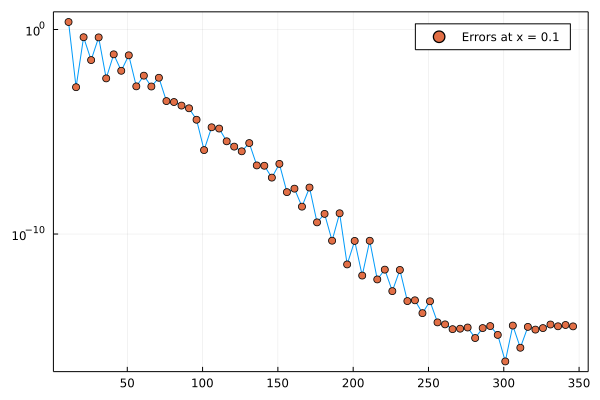

In [56]:
plot(ms,data,yaxis = :log, label = "", grid = true, framestyle = :box)
plot!(ms,data,yaxis = :log, seriestype = :scatter, label = "Errors at x = 0.1")

## Differentiation

To work out how to approximate derivatives, we differentiate

\begin{align*}
I_mf(x) = \frac{1}{m} \sum_{\omega = - m_-}^{m_+} c_{\omega + n_- - n} e^{\pi i \omega x/L}
\end{align*}

giving

\begin{align*}
\frac{d^j}{dx^j} I_mf(x) = \frac{1}{m} \sum_{\omega = - m_-}^{m_+} c_{\omega + m_- - m} (\pi i \omega/L)^j e^{\pi i \omega x/L}
\end{align*}

In [57]:
diffvec = (L,m,j) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^j

#107 (generic function with 1 method)

In [58]:
function diff(tr::trig_interp,j=1)
    return trig_interp(tr.L,diffvec(L,length(tr.c),j).*tr.c)
end

diff (generic function with 8 methods)

In [59]:
L = 10.
m = 51
X = mgrid(m,L)
f = x -> exp.(-cos.(pi*x/L))
df = x -> f(x).*(pi/L)*sin.(pi*x/L)
fm = trig_interp(L,mfft(f(X)));
dfm = diff(fm);

In [60]:
dfm(.1) - df(.1)

1.674441835186613e-15 + 8.394279679061956e-17im

In [61]:
dfm

trig_interp(10.0, ComplexF64[-2.1210015541626536e-14 - 4.8204204300805406e-15im, 1.2658689061616626e-14 - 5.019720586828858e-15im, -8.47059860447775e-16 - 1.812022619390246e-15im, -4.370190232114253e-15 - 6.486345447390427e-15im, 2.975587812363614e-15 + 1.4649047691636253e-15im, 2.615901373506474e-16 - 2.092721098805179e-15im, -1.32539002924328e-15 - 2.65078005848656e-15im, 1.2556326592831074e-14 + 1.004506127426486e-14im, 1.6431970020382122e-14 - 3.7948009258333914e-14im, -5.02253063713243e-15 - 5.31622559482951e-15im  …  1.6741768790441432e-15 + 8.928943354902097e-15im, 1.6431970020382122e-14 + 3.7948009258333914e-14im, 5.650346966773984e-15 - 5.9807537941831985e-15im, 5.913259725781033e-16 - 2.787143716846918e-15im, 2.1354539256259624e-16 + 1.1968520395868932e-15im, 3.0450608545712293e-15 - 1.416215981294424e-15im, -4.3726460929086e-15 + 6.497879440045175e-15im, -8.471859456208351e-16 + 1.811661307342496e-15im, 1.2658698435519339e-14 + 5.019789297598111e-15im, -2.121001221533593e-14

These ideas were pioneered in the `chebfun` package written for Matlab.

## A linear higher-order PDE

Since we are working with Fourier series and Fourier interpolants we will suppose periodic boundary conditions, always.

Consider

\begin{align*}
    \begin{cases} u_t + \gamma u_{xxx} = 0,\\
    u(x,0) = \eta(x). \end{cases}
\end{align*}

It is straightforward to verify that for any constant $\nu$

\begin{align*}
 u(x,t) = e^{i \nu x + i \gamma \nu^3 t}
\end{align*}

is a solution.  This implies that if

\begin{align*}
    \eta(x) = \sum_{\omega=-\infty}^\infty \hat \eta_\omega e^{\pi i \omega x/L}
\end{align*}

then

\begin{align*}
    u(x,t) = \sum_{\omega=-\infty}^\infty \hat \eta_\omega e^{\pi i \omega x/L + i  \gamma (\pi \omega/L)^3 t}
\end{align*}

provided the series converges in a desired sense.  In practice, we approximate $\eta$ using the FFT and then no time-stepping is needed because of this last formula.

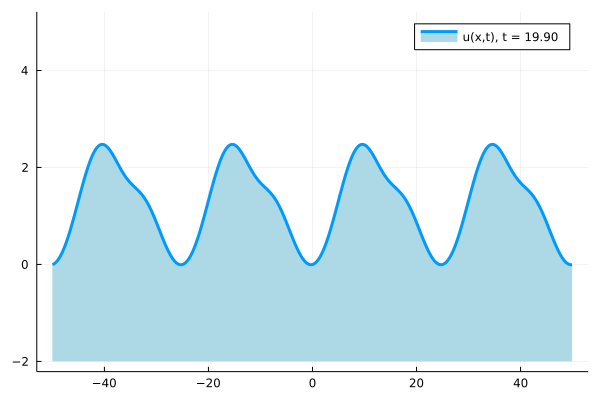

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2022/notebooks/linear_kdv_expcos.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/zozYv/src/animation.jl:114


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2022/notebooks/linear_kdv_expcos.gif")
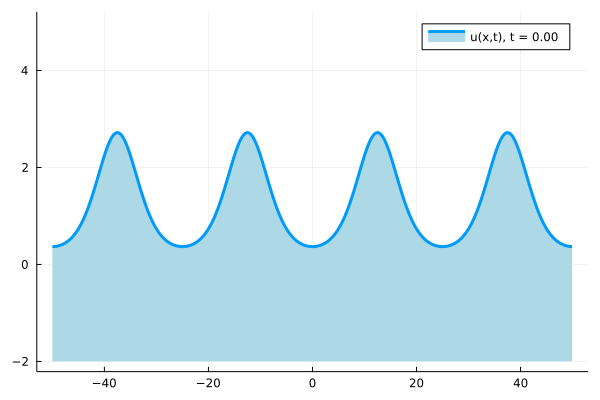

In [64]:
anim = Animation()
η = x -> exp.(-cos.(4*pi*x/L))

L = 50.
m = 2^10
γ = 1.
X = mgrid(m,L)
c = mfft(η(X))
D3 = γ*diffvec(L,m,3)
U = mifft(c)
cl = [-2,5]
k = 0.1
t = 0.0


plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)

for i = 2:200
    t += k
    U = mifft(exp.(-D3*t).*c)
    IJulia.clear_output(true)        
    plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
    frame(anim)
end
gif(anim,"linear_kdv_expcos.gif")

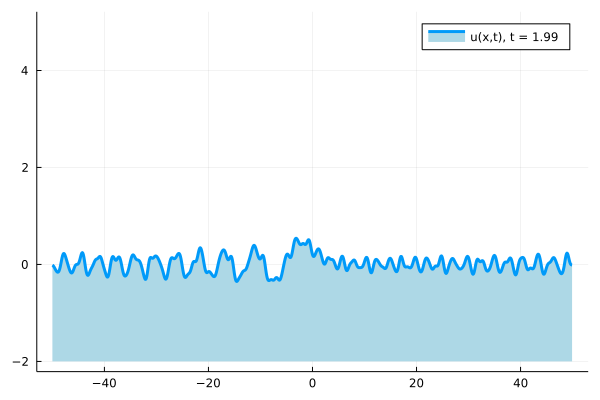

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2022/notebooks/linear_kdv_gauss.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/zozYv/src/animation.jl:114


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2022/notebooks/linear_kdv_gauss.gif")
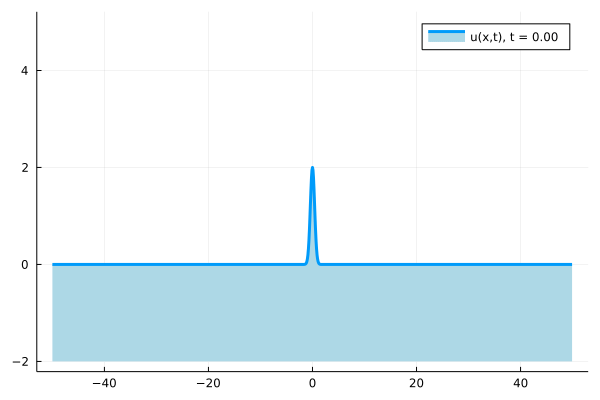

In [65]:
anim = Animation()
η = x -> 2*exp.(-3x.^2)

L = 50.
m = 2^10
γ = 2.
X = mgrid(m,L)
c = mfft(η(X))
D3 = γ*diffvec(L,m,3)
U = mifft(c)
cl = [-2,5]
k = 0.01
t = 0.0


plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)

for i = 2:200
    t += k
    U = mifft(exp.(-D3*t).*c)
    IJulia.clear_output(true)        
    plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
    frame(anim)
end
gif(anim,"linear_kdv_gauss.gif")

While the solution looks interesting, there is no interesting numerical analysis there beyond that which surrounds the FFT because we are essentially just evaluating the series solution.  Things are more interesting when we invoke nonlinearity:

\begin{align*}
    \begin{cases} u_t + \gamma u_{xxx} + 6 u u_x = 0,\\
    u(x,0) = \eta(x). \end{cases}
\end{align*}

This is the celebrated Korteweg-de Vries equation.

One approach would be to treat the linear term with an L-stable method and do Strang splitting with the nonlinearity.  We will take another approach that will allow us to use high-order explicit methods for time stepping.

Supposing that

\begin{align*}
u(x,t) = \sum_{\omega=-\infty}^\infty \hat u_\omega(t) e^{\pi i \omega x /L} =: \mathcal F^{-1} (\hat u)
\end{align*}

we derive a bi-infinite system of **nonlinear** ODEs for $\hat u_\omega(t)$:

\begin{align*}
\hat u'(t) + \gamma \mathcal D^3 \hat u(t) = - 6 \mathcal F \left (\mathcal F^{-1} (\hat u(t)) \mathcal F^{-1} (\mathcal D \hat u(t)) \right).
\end{align*}

Here $\mathcal F$ is the periodic Fourier transform (Fourier series) and $\mathcal D = \mathrm{diag} (\pi i \omega /L)$ as $\omega$ varies from $-\infty$ to $\infty$.

To make this problem computationally tractible we need to first assume that 

\begin{align*}
u(x,t) = \sum_{\omega=-m_-}^{m_+} \hat u_\omega(t) e^{\pi i \omega x /L},
\end{align*}
and we need to replace the full Fourier transform $\mathcal F$ with the FFT, call it $\mathcal F_m$ to keep things finite-dimensional with fixed dimension.

We then get an $m$-dimensional nonlinear system:

\begin{align*}
\hat u'(t) + \gamma \mathcal D_m^3 \hat u(t) = - 6 \mathcal F_m \left (\mathcal F_m^{-1} (\hat u(t)) \mathcal F_m^{-1} (\mathcal D_m \hat u(t)) \right) 
\end{align*}

Sind $2 uu_x = (u^2)_x$, it beneficial to rewrite this as

\begin{align*}
\hat u'(t) = A_m \hat u(t) - 3 \mathcal D_m \mathcal F_m \left (\mathcal F_m^{-1} (\hat u(t))^2 \right) =:  A_m \hat u(t) + \mathcal N(u(t)), \quad A_m = - \gamma \mathcal D_m^3 .
\end{align*}

*** Remark. ***
This appears to be very different approach compared to the MOL lines.  But it is not really.  The MOL approach can be realized in this form if one expands

$$\eta(x) = \sum_{i=0}^{m+1} \eta(x_i) l_i(x)$$

where $l_i(x)$ is a piecewise-linear function satisfying $l_i(x_j) = \delta_{ij}$.  Then one looks for the evolution of the coefficients of $l_i(x)$ by discretizing the problem.  In this setting the "transform" from function values at the mgrid points to coefficients is just the identity map.  In the Fourier setting the transform requires using the FFT which importantly has $O(m \log m)$ complexity.

The matrix $A_m$ has very large entries, in general, expecially if $m$ is large. But it is diagonal.  We would be remiss if we did not use this fact in any way.  

We examine how to step from $t = 0$ to $t = k$.  Since the PDE is autonomous this is sufficient to deal with a general time step.  Define a new unknown $v(t) = e^{-A_m t} \hat u(t)$ so that
\begin{align*}
    v'(t) &=  e^{-A_m t} \hat u'(t) -A_m e^{-A_m t} \hat u(t)  = e^{-A_m t} \mathcal N(\hat u(t)),\\
    \hat u(t) &= e^{A_m t} v(t).
\end{align*}

Examining this over one time step, suppose we have $V^n = \hat U^n$.  And for forward Euler

\begin{align*}
U^{n+1} = U^n + k f(U^n,t_n)
\end{align*}

we write using $t_n = 0$

\begin{align*}
V^1 &= V^0 + k \mathcal N(U^0) = U^0 + k  \mathcal N(U^0),\\
\hat U^1 &= e^{A_mk} V^1.
\end{align*}

For a the two-step method

\begin{align*}
    U^* &= U^n + \frac{k}{2} f(U^n,t_n),\\
    U^{n+1} &= U^n + k f\left( U^*, t_n + \frac k 2 \right)
\end{align*}

we have, again using $t_n = 0$

\begin{align*}
    V^* &=  \hat U^0 + \frac{k}{2}\mathcal N(U^0)\\
    \hat U^* &= e^{A_m k/2} V^*\\
    V^1 &= \hat U^0 + k e^{-A_m k/2} \mathcal N(\hat U^*) = \hat U^0 + k e^{-A_m k/2} \mathcal N(e^{A_m k/2} \hat V^*)
    \hat U^1 = exp(A_m k) V^1
\end{align*}

From this we can see that keeping track of the intermediate value $\hat U^*$ is unnecessary and this this all amounts to applying the multi-stage method with $f(v,t) = e^{-A_m t} \mathcal N(e^{A_m t} v)$ for one step to go from $V^n = U^n$ to $V^{n+1}$ and then setting $U^{n+1} = e^{A_m t}V^{n+1}$.

Since $D_n^3$ has purely imaginary diagonal entries $\exp( D_n^3)$ is bounded and we can hope that explicit methods can be stable.  Furthermore, since the nonlinearity $\mathcal N$ involves only the first derivative we have more evidence to hope that explicit methods work well.  The code below implements the nonlinearity and applies Runge-Kutta 4.

***Remark.*** An alternate approach proceeds by discretizing the Duhamel integral

\begin{align*}
  \hat u(t) = e^{A_m t} \hat u(0) + \int_0^t e^{A_m (t-\tau)} \mathcal N(\hat u(\tau)) d \tau.
\end{align*}

See Section 11.6 for references.

In [ ]:
function rk4(F,k,t,c)
    f1 = k*F(c,t)
    f2 = k*F(c + .5*f1, t + .5*k)
    f3 = k*F(c + .5*f2, t + .5*k)
    f4 = k*F(c + f3, t + k)
    return c + 1/6.0*(f1 + 2.0*f2 + 2.0*f3 + f4)
end

In [ ]:
anim = Animation()
T = 4
η = x -> exp.(-cos.(4*pi*x/L))

L = 50.
m = 2^10
k = 0.0001

γ = 1.
X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-1,6]

D = diffvec(L,m,1)
Am = -γ*diffvec(L,m,3)

F = (v,τ) -> -3*exp.(-Am*τ).*(D.*mfft(mifft(exp.(Am*τ).*v).^2))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(Am*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)        
        plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
        frame(anim)
    end
end
gif(anim,"kdv_expcos.gif")


In [ ]:
anim = Animation()
T = 4
η = x -> 2*exp.(-3x.^2)

L = 50.
m = 2^10
k = 0.0001

γ = 1.
X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-1,6]

D = diffvec(L,m,1)
Am = -γ*diffvec(L,m,3)

F = (v,τ) -> -3*exp.(-Am*τ).*(D.*mfft(mifft(exp.(Am*τ).*v).^2))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(Am*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)        
        plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
        frame(anim)
    end
end
gif(anim,"kdv_gauss.gif")

In [ ]:
anim = Animation()
T = 4
A = 3.0
η = x -> A*sech.(sqrt(A/2)*x).^2

L = 50.
m = 2^10
k = 0.0001

γ = 1.
X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-4,4]

D = diffvec(L,m,1)
Am = -γ*diffvec(L,m,3)

F = (v,τ) -> -3*exp.(-Am*τ).*(D.*mfft(mifft(exp.(Am*τ).*v).^2))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(Am*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)        
        plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
        frame(anim)
    end
end
gif(anim,"kdv_sech.gif")


In [ ]:
anim = Animation()
T = 4
A = 3.0
η = x -> -A*sech.(sqrt(A/2)*x).^2

L = 50.
m = 2^10
k = 0.0001

γ = 1.
X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-4,4]

D = diffvec(L,m,1)
Am = -γ*diffvec(L,m,3)

F = (v,τ) -> -3*exp.(-Am*τ).*(D.*mfft(mifft(exp.(Am*τ).*v).^2))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display
frame(anim)
fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(Am*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)        
        plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("u(x,t), t = %1.2f",t), fill = (cl[1],:lightblue)) |> IJulia.display  
        frame(anim)
    end
end
gif(anim,"kdv_neg_sech.gif")


# Two spatial dimensions

In [ ]:
mfft2D = X -> X |> mfft |> transpose |> mfft |> transpose
mifft2D = X -> X |> transpose |> mifft |> transpose |> mifft

In [ ]:
L = 5.
m = 2^6
X = mgrid(m,L)
f = (x,y) -> exp.(0*1im*pi*x/L).*exp.(1im*pi*y/L)
f = (x,y) -> exp.(-2(x.^2 .+ 1.5*y.^2))
fx = (x,y) -> (-4*x).*f(x,y)
fy = (x,y) -> (-6*y).*f(x,y)

In [ ]:
c = f.(X,X') |> mfft2D;

In [ ]:
struct trig_interp_2D
    L::Float64 # assume a square
    c::Matrix{Complex{Float64}}
end

function (tr::trig_interp_2D)(x,y)
    m = length(tr.c[1,:])
    mm = convert(Int64,floor( m/2 ))
    σ = isodd(m) ? 1im*pi/m : 0. # if n is odd we need to rotate coefs
    ex = exp.(-1im*pi*mm*y/tr.L + mm*σ)
    ex1 = exp.(1im*pi*y/tr.L-σ)
    tr1d = trig_interp(tr.L,tr.c[:,1])
    sum = tr1d(x)*ex
    for i = 2:m
        tr1d = trig_interp(tr.L,tr.c[:,i])
        ex  =  ex.*ex1
        sum += tr1d(x)*ex
    end
    return sum/m
end    

In [ ]:
tr = trig_interp_2D(L,c);

In [ ]:
tr(.3,-.45) - f(.3,-.45)

In [ ]:
D = diffvec(L,m,1)
F = (x,y) -> (x,y)
Dxy = F.(D,transpose(D));

In [ ]:
cx = map( x -> x[1], Dxy).*c;
trx = trig_interp_2D(L,cx);
trx(.3,-.45) - fx(.3,-.45)

In [ ]:
cy = map( x -> x[2], Dxy).*c;
tr_y = trig_interp_2D(L,cy);
tr_y(.3,-.45) - fy(.3,-.45)

# Nonlinear Schrödinger equation in one spatial dimension


Consider solving

$$i u_t + u_{xx} + 2 u |u|^2 = 0$$

In [ ]:
anim = Animation()
T = 4
η = x -> 2*exp.(-3x.^2 .+ 1im*x)

L = 50.
m = 2^10
k = 0.0001

X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-2,2]

d2 = 1im*diffvec(L,m,2)

N = v -> 2im*v.*abs2.(v)

F = (v,τ) -> exp.(-d2*τ).*(mfft(N(mifft(exp.(d2*τ).*v))))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Re u(x,t), t = %1.2f",t))
plot!(X, U |> imag, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Im u(x,t), t = %1.2f",t)) |> IJulia.display
frame(anim)
fr = 50 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(d2*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)        
        plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Re u(x,t), t = %1.2f",t) ) 
        plot!(X, U |> imag, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Im u(x,t), t = %1.2f",t) ) |> IJulia.display  
        frame(anim)
    end
end
#gif(anim,"kdv_gauss.gif")

In [ ]:
anim = Animation()
T = 4
η = x -> sech.(x).*exp.(1im*x)

L = 50.
m = 2^10
k = 0.0001

X = mgrid(m,L)
c = mfft(η(X))
U = mifft(c)
cl = [-2,2]

d2 = 1im*diffvec(L,m,2)

N = v -> 2im*v.*abs2.(v)

F = (v,τ) -> exp.(-d2*τ).*(mfft(N(mifft(exp.(d2*τ).*v))))

n = convert(Int64,ceil(T/k))
t = 0.0
plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Re u(x,t), t = %1.2f",t))
plot!(X, U |> imag, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Im u(x,t), t = %1.2f",t)) |> IJulia.display
frame(anim)
fr = 50 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(d2*k).*rk4(F,k,0.0,c)
    t += k
    U = mifft(c)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)        
        plot(X, U |> real, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Re u(x,t), t = %1.2f",t) ) 
        plot!(X, U |> imag, xaxis = [-L,L], yaxis = cl, lw=3,label = @sprintf("Im u(x,t), t = %1.2f",t) ) |> IJulia.display  
        frame(anim)
    end
end
#gif(anim,"kdv_gauss.gif")

# Nonlinear Schrödinger equation in two spatial dimensions


Consider solving

$$i u_t + u_{xx} +u_{yy} + 2 u |u|^2 = 0$$

In [ ]:
function plot_NLS(U,x,y,t,cl,width=800)
    p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = .6, xlabel = L"x", ylabel = L"y", zlabel = L"Re u(x,y,t)")
    p2 = contour(x, y, U[end:-1:1,:], clims=cl, fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
    plot(p1, p2, layout = 2, size = (width, 7*width/10), title = @sprintf("t = %1.4f",t))
end

In [ ]:
T = 20.0
L = 30.
m = 2^7
k = 0.0005
k₀ = 4*pi/L*10

In [ ]:
anim = Animation()

#η = (x,y) -> 2*exp.(-3x.^2 .- y.^2 .+ 1im*x) + exp.(1im*x*k₀)
η = (x,y) -> sech.(y).*exp(3im*y) + 0.001*sin.(x*k₀).*exp(-x.^2)

# η₀ = (x,y) -> sech.(x)
# U₀ = η₀.(X,X')

X = mgrid(m,L)
c = η.(X,X') |> mfft2D;
U = mifft2D(c)

cl = (-1.3,1.5)
t = 0.0

plot_NLS(U|> real,X,X,t,cl) |> IJulia.display
frame(anim)

D = 1im*diffvec(L,m,2)
F = (x,y) -> (x,y)
Dxy = F.(D,transpose(D));

d2x = map( x-> x[1], Dxy)
d2y = map( x-> x[2], Dxy)
d2 = d2x + d2y
N = v -> 2im*v.*abs2.(v)

F = (v,τ) -> exp.(-d2*τ).*(mfft2D(N(mifft2D(exp.(d2*τ).*v))))

n = convert(Int64,ceil(T/k))

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    c = exp.(d2*k).*rk4(F,k,0.0,c)
    t += k
    if mod(i-1,tb) ≈ 0.0
        U = mifft2D(c)
        IJulia.clear_output(true)        
        plot_NLS(U |> real,X,X,t,cl) |> IJulia.display
        frame(anim)
    end
end
gif(anim,"cubic_nls.gif")

In [ ]:
cl